# t-Distributed Stochastic Neighbor Embedding (t-SNE)

Este notebook explora o t-SNE, uma técnica de redução de dimensionalidade não linear particularmente eficaz para a visualização de datasets de alta dimensão. Diferentemente de métodos como o PCA, que se concentram em preservar a variância global, o t-SNE foca em preservar a estrutura local, ou seja, as similaridades entre pontos vizinhos. Ele modela as similaridades entre pontos de dados tanto no espaço de alta dimensão quanto no de baixa dimensão e busca minimizar a divergência entre essas duas distribuições de similaridade.

## Fundamentação

O t-SNE opera em duas etapas principais: primeiro, ele constrói uma distribuição de probabilidade sobre pares de pontos de dados de alta dimensão, de modo que pontos similares tenham uma alta probabilidade de serem escolhidos, enquanto pontos dissimilares tenham uma probabilidade extremamente baixa. Segundo, ele define uma distribuição de probabilidade similar sobre os pontos no mapa de baixa dimensão e minimiza a divergência de Kullback-Leibler (KL) entre as duas distribuições em relação às localizações dos pontos no mapa.

### Similaridades no Espaço de Alta Dimensão

A similaridade entre os pontos de dados $x_i$ e $x_j$ é a probabilidade condicional, $p_{j|i}$, de que $x_i$ escolheria $x_j$ como seu vizinho se os vizinhos fossem escolhidos em proporção à sua densidade de probabilidade sob uma Gaussiana centrada em $x_i$. A probabilidade é dada por:

$$
p_{j|i} = \frac{\exp(-\|x_i - x_j\|^2 / 2\sigma_i^2)}{\sum_{k \neq i} \exp(-\|x_i - x_k\|^2 / 2\sigma_i^2)}
$$

A variância da Gaussiana, $\sigma_i^2$, é determinada para cada ponto de dados individualmente através de uma busca binária. Essa busca é realizada para encontrar um $\sigma_i$ que produza uma distribuição de probabilidade $P_i$ com uma perplexidade específica, um hiperparâmetro definido pelo usuário. A perplexidade pode ser interpretada como uma medida suave do número efetivo de vizinhos para cada ponto.

Para obter uma distribuição de probabilidade conjunta, o t-SNE simetriza essas probabilidades condicionais:

$$
p_{ij} = \frac{p_{j|i} + p_{i|j}}{2n}
$$

onde $n$ é o número de pontos de dados.

### Similaridades no Espaço de Baixa Dimensão

No espaço de baixa dimensão (geralmente 2D ou 3D), o t-SNE utiliza uma distribuição t de Student com um grau de liberdade (que é equivalente a uma distribuição de Cauchy) para medir as similaridades entre os pontos de baixa dimensão $y_i$ e $y_j$. O uso de uma distribuição de cauda longa como a t de Student permite que pontos moderadamente distantes no espaço de alta dimensão sejam mapeados para distâncias maiores no espaço de baixa dimensão, ajudando a aliviar o problema de "crowding" (aglomeração). A probabilidade conjunta $q_{ij}$ é definida como:

$$
q_{ij} = \frac{(1 + \|y_i - y_j\|^2)^{-1}}{\sum_{k \neq l} (1 + \|y_k - y_l\|^2)^{-1}}
$$

### Otimização via Minimização da Divergência KL

O objetivo do t-SNE é fazer com que a distribuição $Q$ (no espaço de baixa dimensão) reflita a distribuição $P$ (no espaço de alta dimensão) da melhor forma possível. Isso é alcançado minimizando a divergência de Kullback-Leibler entre as duas distribuições:

$$
C = \text{KL}(P||Q) = \sum_{i} \sum_{j} p_{ij} \log \frac{p_{ij}}{q_{ij}}
$$

A minimização desta função de custo é realizada usando o método do gradiente descendente. O gradiente da divergência KL em relação aos pontos no embedding $y_i$ possui uma forma surpreendentemente simples, que é a diferença entre as forças de atração (puxando pontos similares para perto) e as forças de repulsão (empurrando pontos dissimilares para longe).

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.manifold import TSNE
import seaborn as sns

### Gerando um Dataset Sintético

Para demonstrar o t-SNE, vamos primeiro gerar um conjunto de dados sintético com clusters bem definidos. Usaremos a função `make_blobs` da biblioteca `scikit-learn`.

In [3]:
n_samples = 300
n_features = 20
n_clusters = 5

X, y = make_blobs(
    n_samples=n_samples,
    n_features=n_features,
    centers=n_clusters,
    random_state=42,
    cluster_std=5.0
)

print("Formato do dataset X:", X.shape)
print("Formato do vetor y:", y.shape)

Formato do dataset X: (300, 20)
Formato do vetor y: (300,)


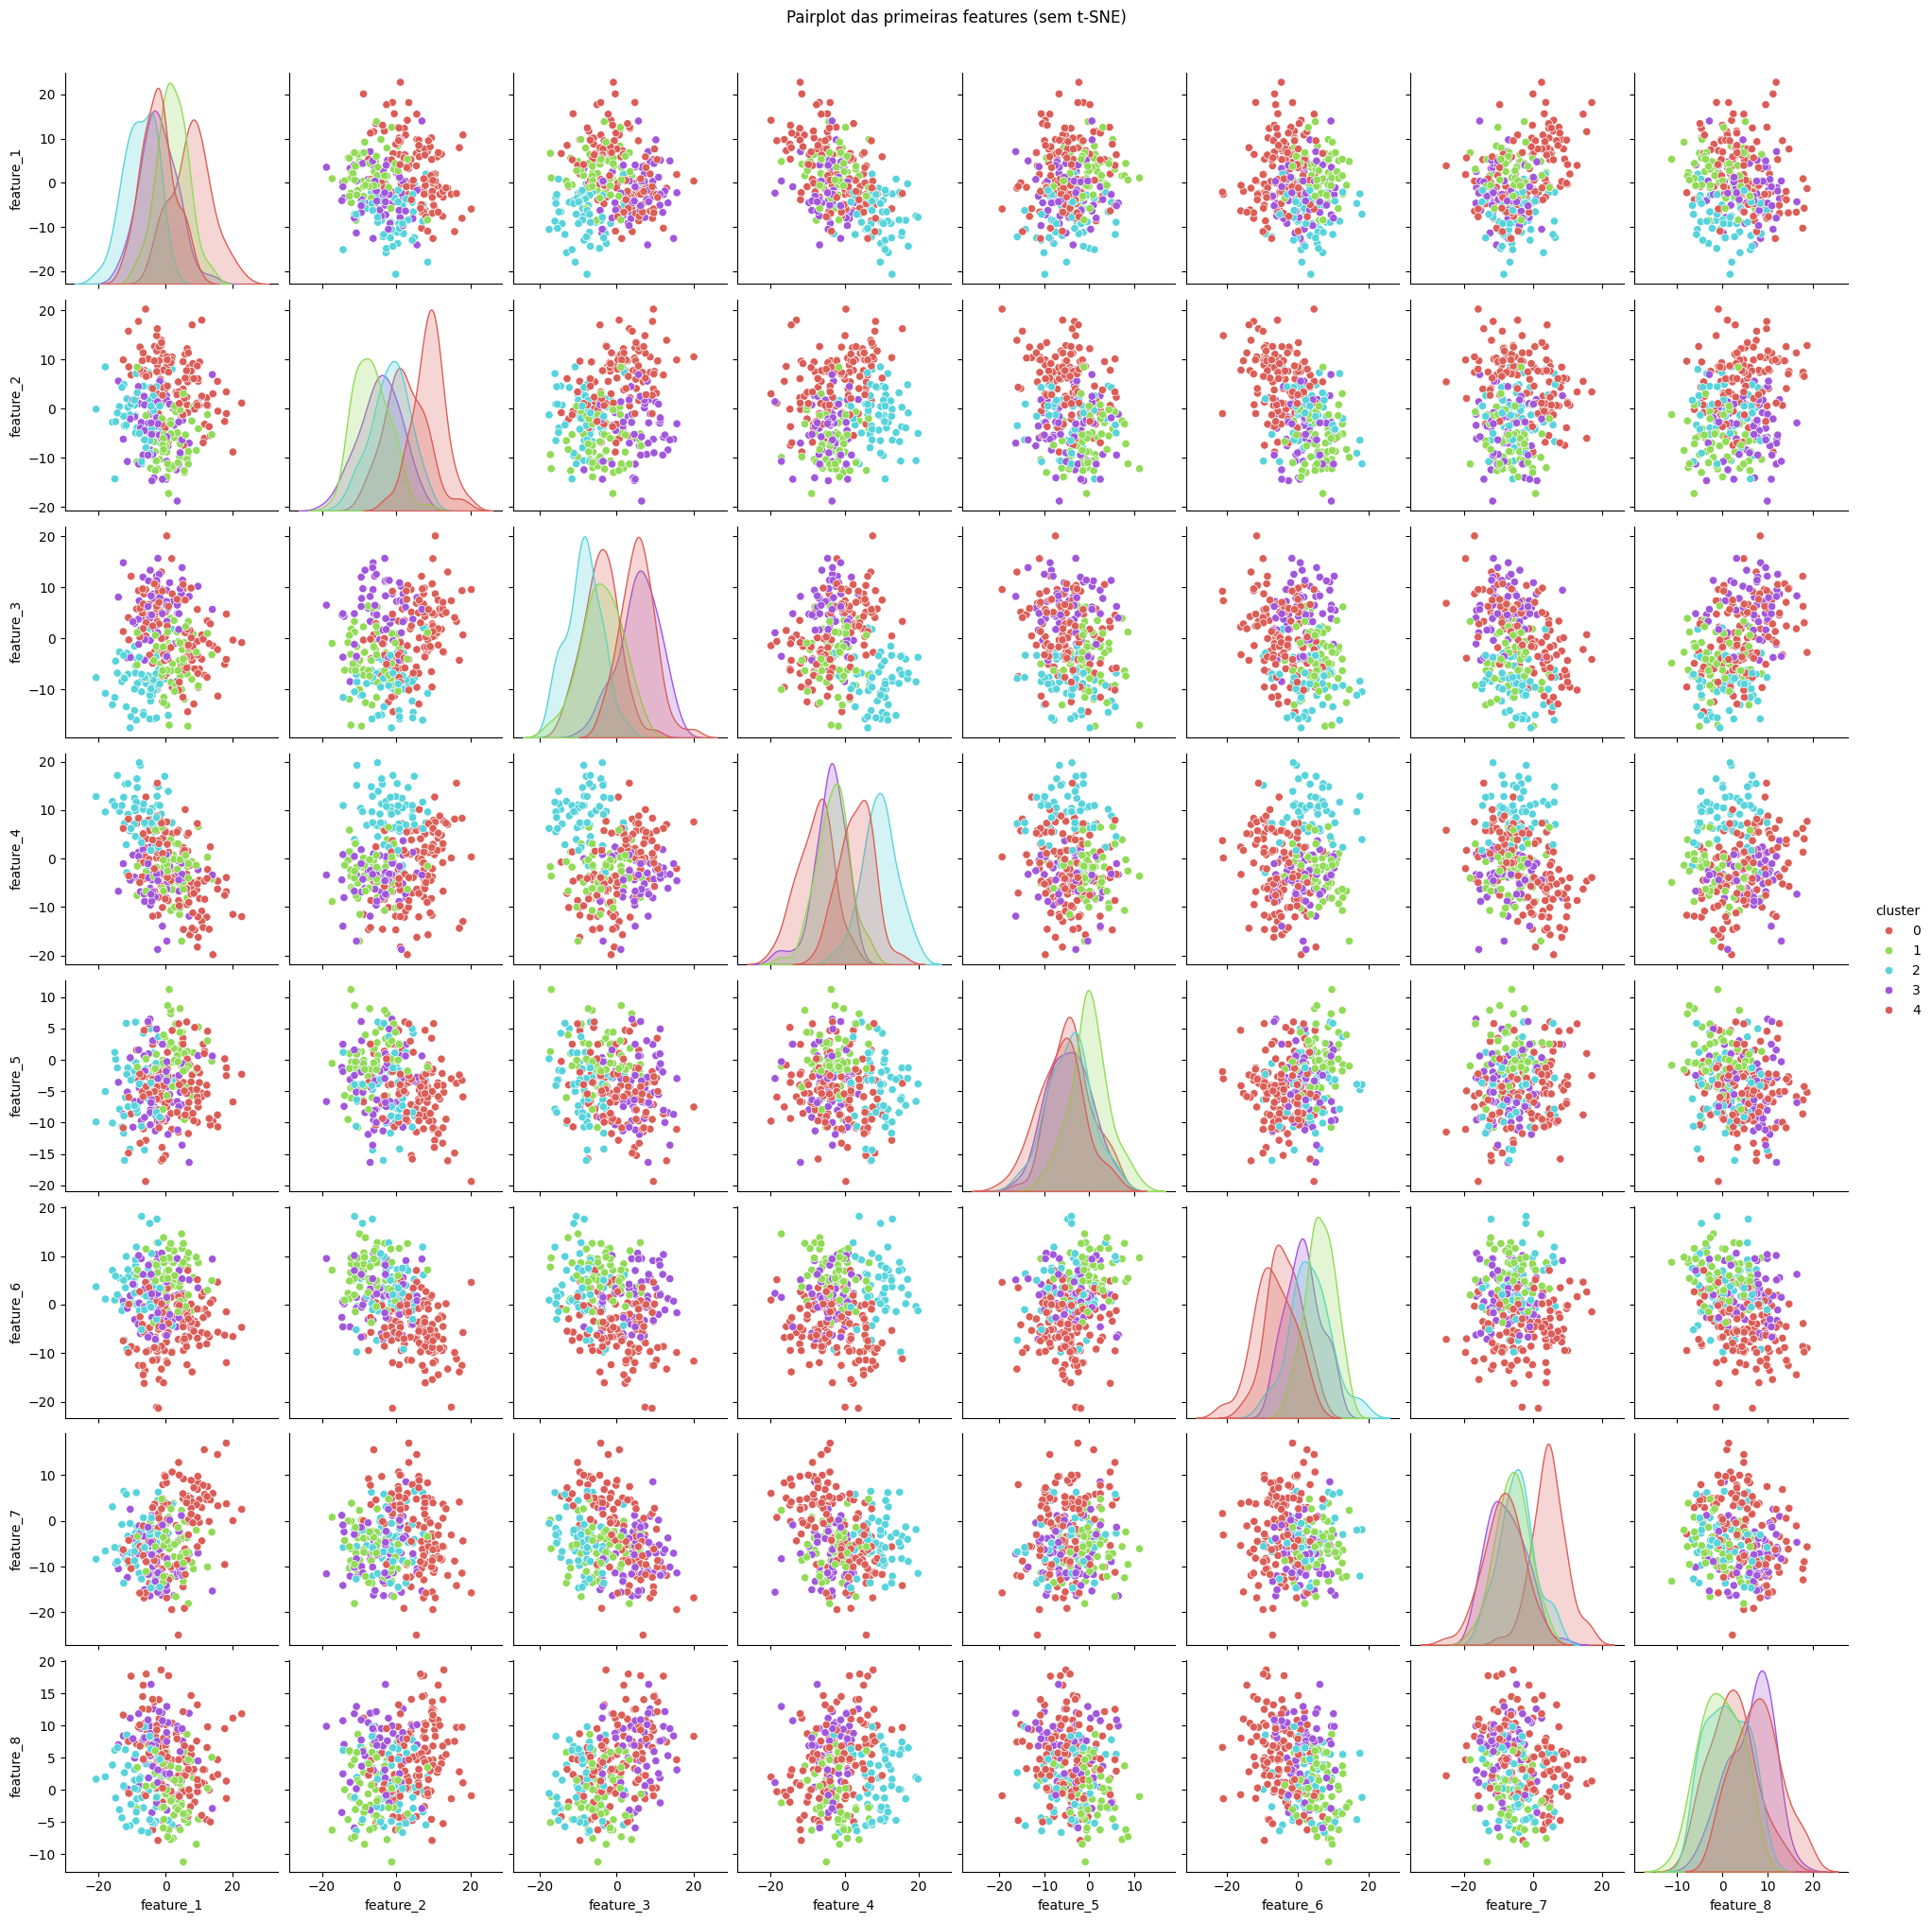

In [4]:
df = pd.DataFrame(X[:, :8], columns=[f'feature_{i+1}' for i in range(8)])
df['cluster'] = y

sns.pairplot(df, hue='cluster', palette='hls')
plt.suptitle("Pairplot das primeiras features (sem t-SNE)", y=1.02)
plt.show()

## Implementação da Classe t-SNE

Agora, vamos implementar o algoritmo t-SNE, encapsulando a lógica em uma classe Python com uma interface similar à do `scikit-learn`. Esta implementação se concentrará na clareza do algoritmo, em vez de otimizações de performance.

In [5]:
class TSNE:
    def __init__(self, n_components=2, perplexity=30.0, lr=200.0, n_iter=500):
        # Número de dimensões finais, perplexidade, taxa de aprendizado e iterações
        self.n_components = n_components
        self.perplexity = perplexity
        self.lr = lr
        self.n_iter = n_iter

    # -------------------------------------------------------
    # 1. Calcula matriz de distâncias euclidianas ao quadrado
    # -------------------------------------------------------
    def _distances(self, X):
        sum_X = np.sum(X**2, axis=1)
        return np.add(np.add(-2 * X @ X.T, sum_X).T, sum_X)

    # -------------------------------------------------------------------------
    # 2. Calcula a matriz P (probabilidades no espaço de alta dimensão)
    #    Cada linha P[i] é ajustada para ter uma entropia que corresponda à perplexidade
    # -------------------------------------------------------------------------
    def _p_matrix(self, D):
        n = D.shape[0]
        P = np.zeros((n, n))
        logU = np.log2(self.perplexity)

        for i in range(n):
            beta = 1.0  # inverso da variância (1 / (2*sigma²))
            Di = np.delete(D[i], i)  # remove a distância com ele mesmo

            # Ajuste de beta por busca simples até alcançar a perplexidade desejada
            for _ in range(30):
                P_i = np.exp(-Di * beta)
                P_i /= np.sum(P_i)
                H = -np.sum(P_i * np.log2(P_i + 1e-12))  # entropia
                if abs(H - logU) < 1e-3:  # se já está próximo, para
                    break
                beta *= 1.2 if H > logU else 0.8  # ajusta beta

            P[i, np.arange(n) != i] = P_i

        # Simetriza e normaliza
        P = (P + P.T) / (2 * n)
        return np.maximum(P, 1e-12)

    # -------------------------------------------------------
    # 3. Executa o t-SNE e retorna o embedding 2D
    # -------------------------------------------------------
    def fit_transform(self, X):
        n = X.shape[0]

        # Calcula afinidades no espaço original (P)
        D = self._distances(X)
        P = self._p_matrix(D)

        # Inicializa o embedding aleatoriamente
        Y = np.random.randn(n, self.n_components)

        # Loop de otimização
        for it in range(self.n_iter):
            # Calcula afinidades no espaço de baixa dimensão (Q)
            sum_Y = np.sum(Y**2, axis=1)
            num = 1 / (1 + np.add(np.add(-2 * Y @ Y.T, sum_Y).T, sum_Y))
            np.fill_diagonal(num, 0)
            Q = np.maximum(num / np.sum(num), 1e-12)

            # Calcula o gradiente
            PQ = P - Q
            for i in range(n):
                # Soma ponderada das diferenças (força de atração/repulsão)
                dY_i = np.sum((PQ[:, i] * num[:, i])[:, None] * (Y[i] - Y), axis=0)
                Y[i] -= self.lr * dY_i  # Atualiza posição

            # Centraliza os pontos
            Y -= np.mean(Y, axis=0)

            # Mostra custo a cada 100 iterações
            if (it + 1) % 100 == 0:
                cost = np.sum(P * np.log(P / Q))
                print(f"Iter {it+1:4d}: cost = {cost:.4f}")

        return Y

### Aplicando

Vamos agora instanciar nossa classe `TSNE` e aplicá-la ao mesmo dataset sintético. O processo de otimização será impresso, mostrando o valor da função de custo em intervalos regulares.

In [6]:
custom_tsne = TSNE(n_components=2, perplexity=30.0, n_iter=1000, lr=200)
X_embedded_custom = custom_tsne.fit_transform(X)

/tmp/ipython-input-26374851.py:32: RuntimeWarning: invalid value encountered in divide
  P_i /= np.sum(P_i)


Iter  100: cost = 0.7484
Iter  200: cost = 0.6454
Iter  300: cost = 0.6094
Iter  400: cost = 0.5902
Iter  500: cost = 0.5775
Iter  600: cost = 0.5685
Iter  700: cost = 0.5616
Iter  800: cost = 0.5560
Iter  900: cost = 0.5514
Iter 1000: cost = 0.5451


### Visualizando o Resultado da Implementação

Finalmente, plotamos o resultado gerado pela nossa implementação.

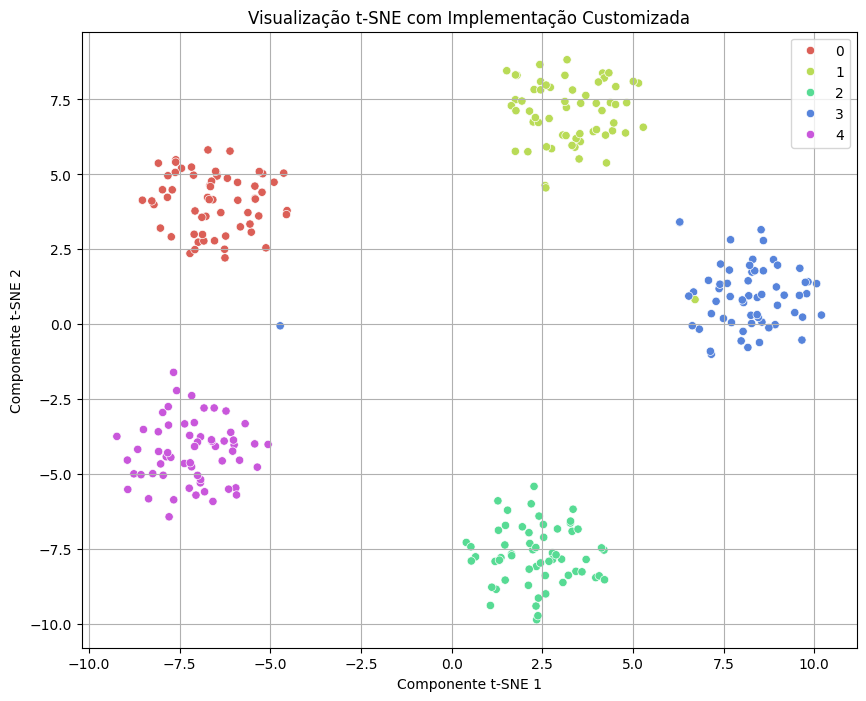

In [7]:
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=X_embedded_custom[:, 0],
    y=X_embedded_custom[:, 1],
    hue=y,
    palette=sns.color_palette("hls", n_clusters),
    legend="full"
)
plt.title('Visualização t-SNE com Implementação Customizada')
plt.xlabel('Componente t-SNE 1')
plt.ylabel('Componente t-SNE 2')
plt.grid(True)
plt.show()

## Exercícios

### Exercício 1

Treine diferentes modelos t-SNE em 2D com diferentes valores de perplexidade para o dataset sintético e plote cada um deles.

/tmp/ipython-input-26374851.py:32: RuntimeWarning: invalid value encountered in divide
  P_i /= np.sum(P_i)


Iter  100: cost = 1.4686
Iter  200: cost = 1.2588
Iter  300: cost = 1.1517
Iter  400: cost = 1.0927
Iter  500: cost = 1.0561
Iter  600: cost = 1.0271
Iter  700: cost = 1.0032
Iter  800: cost = 0.9825
Iter  900: cost = 0.9671
Iter 1000: cost = 0.9546
Iter  100: cost = 1.0118
Iter  200: cost = 0.8734
Iter  300: cost = 0.8243
Iter  400: cost = 0.7935
Iter  500: cost = 0.7726
Iter  600: cost = 0.7579
Iter  700: cost = 0.7468
Iter  800: cost = 0.7378
Iter  900: cost = 0.7304
Iter 1000: cost = 0.7239
Iter  100: cost = 0.6080
Iter  200: cost = 0.5048
Iter  300: cost = 0.4781
Iter  400: cost = 0.4563
Iter  500: cost = 0.4467
Iter  600: cost = 0.4400
Iter  700: cost = 0.4353
Iter  800: cost = 0.4316
Iter  900: cost = 0.4286
Iter 1000: cost = 0.4261
Iter  100: cost = 0.2636
Iter  200: cost = 0.2257
Iter  300: cost = 0.2162
Iter  400: cost = 0.2117
Iter  500: cost = 0.2091
Iter  600: cost = 0.2073
Iter  700: cost = 0.2061
Iter  800: cost = 0.2051
Iter  900: cost = 0.2040
Iter 1000: cost = 0.2035


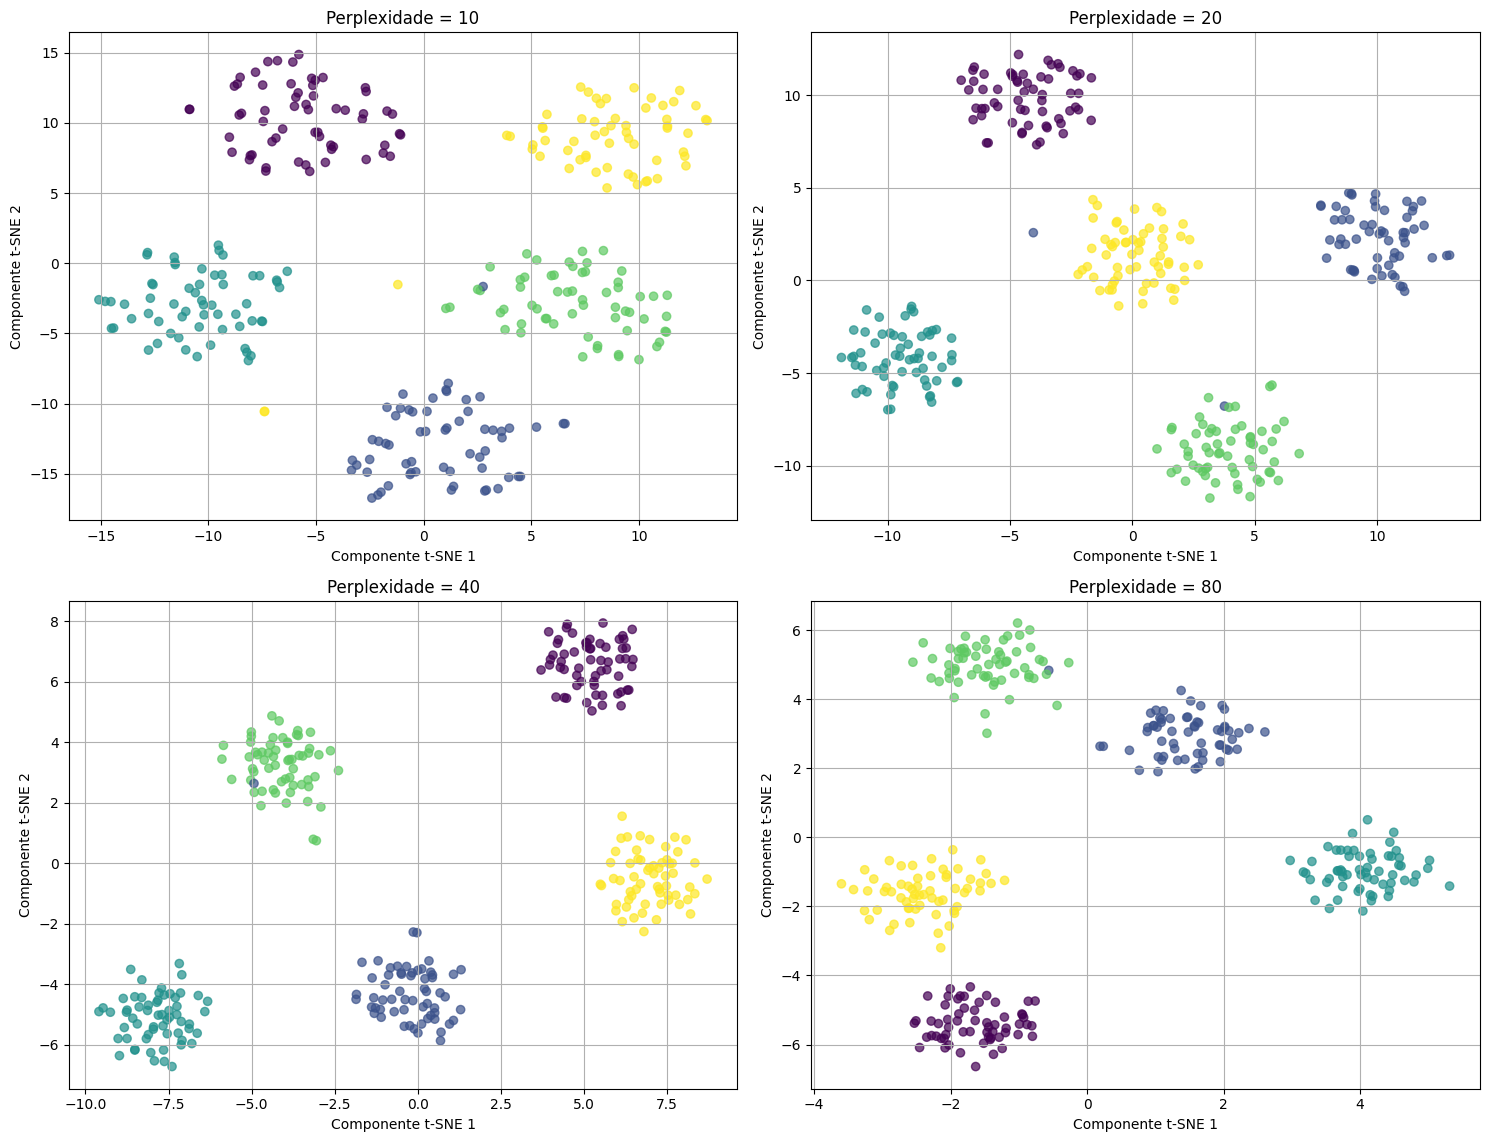

In [8]:
n_per = [10, 20, 40, 80]

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

for i, perplexity in enumerate(n_per):

    tsne_custom = TSNE(n_components=2, perplexity=perplexity, n_iter=1000, lr=200)

    X_tsne_custom = tsne_custom.fit_transform(X)
    ax = axes[i]

    scatter = ax.scatter(X_tsne_custom[:, 0], X_tsne_custom[:, 1], c=y, cmap='viridis', alpha=0.7)

    ax.set_title(f'Perplexidade = {perplexity}')
    ax.set_xlabel('Componente t-SNE 1')
    ax.set_ylabel('Componente t-SNE 2')
    ax.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


### Exercício 2

Faça um treinamento de um modelo t-SNE para o Dataset Wine. Em seguida, plote o resultado em duas dimensões.

Wine shape: (178, 13) | N classes: 3
Iter  100: cost = 0.4805
Iter  200: cost = 0.4423
Iter  300: cost = 0.4299
Iter  400: cost = 0.4237
Iter  500: cost = 0.4199
Iter  600: cost = 0.4173
Iter  700: cost = 0.4151
Iter  800: cost = 0.4120
Iter  900: cost = 0.4102
Iter 1000: cost = 0.4067


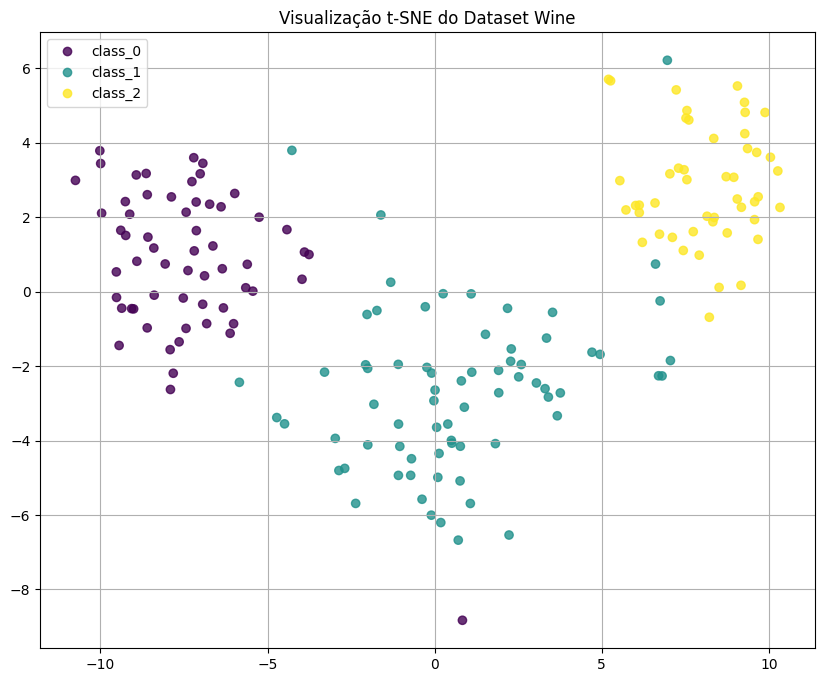

In [9]:
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler

wine = load_wine()
X_wine = wine.data
Y_wine = wine.target

X_wine_scaled = StandardScaler().fit_transform(X_wine)
print(f"Wine shape: {X_wine_scaled.shape} | N classes: {len(np.unique(Y_wine))}")


tsne_wine = TSNE(n_components=2, perplexity=32.0, n_iter=1000, lr=200)
X_wine_tsne = tsne_wine.fit_transform(X_wine_scaled)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_wine_tsne[:, 0], X_wine_tsne[:, 1], c=Y_wine, cmap='viridis', alpha=0.8)

plt.legend(handles=scatter.legend_elements()[0], labels=list(wine.target_names))
plt.title('Visualização t-SNE do Dataset Wine')
plt.grid(True)
plt.show()
